In [ ]:
# Run in Colab to install local packages
!pip install datasets gensim

In [65]:
import os
import datasets
import gensim
import gensim.downloader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
sciq = datasets.load_dataset("allenai/sciq")

Generating train split:   0%|          | 0/11679 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [27]:
train = sciq["train"]

In [4]:
print(train[0])

{'question': 'What type of organism is commonly used in preparation of foods such as cheese and yogurt?', 'distractor3': 'viruses', 'distractor1': 'protozoa', 'distractor2': 'gymnosperms', 'correct_answer': 'mesophilic organisms', 'support': 'Mesophiles grow best in moderate temperature, typically between 25°C and 40°C (77°F and 104°F). Mesophiles are often found living in or on the bodies of humans or other animals. The optimal growth temperature of many pathogenic mesophiles is 37°C (98°F), the normal human body temperature. Mesophilic organisms have important uses in food preparation, including cheese, yogurt, beer and wine.'}


In [13]:
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [5]:
# fasttext = gensim.downloader.load("fasttext-wiki-news-subwords-300")
fasttext = gensim.models.KeyedVectors.load("ft") #, mmap='r'

In [6]:
print(fasttext.similarity('viruses', 'protozoa'))
print(fasttext.similarity('protozoa', 'viruses'))

0.52428013
0.52428013


In [42]:
train_df = train
train_df.set_format("pandas")
train_df = train_df[:]
train_df["len_correct_answer"] = train_df["correct_answer"].apply(lambda x: len(x.split(" ")))
# train_df["max_len"] = train.map(lambda x: max([len(x[y].split(" ")) for y in ["correct_answer", "distractor1", "distractor2", "distractor3"]]))

frequencies = (
#     train_df["len_correct_answer"]
    bla["max_length"]
    .value_counts()
    .to_frame()
    .reset_index()
#     .rename(columns={"index": "number of words", "len_correct_answer": "frequency"})
)
train.set_format()
frequencies

,index,max_length
0,1,6204
1,2,4018
2,3,1142
3,4,196
4,5,64
5,6,26
6,7,14
7,8,5
8,9,3
9,10,3


In [43]:
def get_max_length(sample):
    return {
        "max_length":max([len(sample[y].split(" ")) for y in ["correct_answer", "distractor1", "distractor2", "distractor3"]])
    }
train =  train.map(get_max_length, remove_columns=["question", "support"])

Map:   0%|          | 0/11679 [00:00<?, ? examples/s]

In [7]:
def get_similarities(sample):
    if len(sample["correct_answer"].split(' ')) > 1:
        return {
             "correct_to_distractor": [None],
            "distractor_to_distractor": [None],
        }
    try:
        return {
            "correct_to_distractor": [fasttext.similarity(sample["correct_answer"], sample[distractor]) for distractor in ["distractor1", "distractor2", "distractor3"]],
            "distractor_to_distractor": [fasttext.similarity(sample["distractor"+str(a)], sample["distractor"+str(b)]) for a, b in [(1,2), (1,3), (2,3)]],
        }
    except KeyError:
        return {
             "correct_to_distractor": [None],
            "distractor_to_distractor": [None],
        }

In [9]:
small = train.select([i for i in range(10)])
print(small)
print(small[0])

Dataset({
    features: ['question', 'distractor3', 'distractor1', 'distractor2', 'correct_answer', 'support'],
    num_rows: 10
})
{'question': 'What type of organism is commonly used in preparation of foods such as cheese and yogurt?', 'distractor3': 'viruses', 'distractor1': 'protozoa', 'distractor2': 'gymnosperms', 'correct_answer': 'mesophilic organisms', 'support': 'Mesophiles grow best in moderate temperature, typically between 25°C and 40°C (77°F and 104°F). Mesophiles are often found living in or on the bodies of humans or other animals. The optimal growth temperature of many pathogenic mesophiles is 37°C (98°F), the normal human body temperature. Mesophilic organisms have important uses in food preparation, including cheese, yogurt, beer and wine.'}


In [10]:
get_similarities(small[0])

{'correct_to_distractor': [None], 'distractor_to_distractor': [None]}

In [11]:
similarities = small.map(get_similarities, remove_columns=["question", "support"])

Map (num_proc=2):   0%|          | 0/10 [00:00<?, ? examples/s]

In [15]:
similarities[5]

{'distractor3': 'orbit',
 'distractor1': 'comet',
 'distractor2': 'meteor',
 'correct_answer': 'meteorite',
 'correct_to_distractor': [0.5626466870307922,
  0.7525315880775452,
  0.3713691830635071],
 'distractor_to_distractor': [0.5364603996276855,
  0.40672171115875244,
  0.3779737949371338]}

In [63]:
ansToDist = []
distToDist = []
for i, sample in enumerate(train):
    if sample["max_length"] > 1:
        continue
    try:
        sim = [fasttext.similarity(sample["correct_answer"], sample[distractor]) for distractor in ["distractor1", "distractor2", "distractor3"]]
        ansToDist.extend(sim)
        if max(sim) >= 1.0:
            print(i)
        sim = [fasttext.similarity(sample["distractor"+str(a)], sample["distractor"+str(b)]) for a, b in [(1,2), (1,3), (2,3)]]
        distToDist.extend(sim)
    except KeyError:
        continue

1481
4997
5387
5558
11108
11116


In [48]:
len(ansToDist)

17109

In [54]:
ansToDistDF = pd.DataFrame(ansToDist)
ansToDistDF.describe()

,0
count,17109.000000
mean,0.511500
std,0.141269
min,-0.056659
25%,0.420177
50%,0.496206
75%,0.589245
max,1.000000


In [53]:
distToDistDF = pd.DataFrame(distToDist)
distToDistDF.describe()

,0
count,17109.000000
mean,0.469450
std,0.139733
min,-0.020514
25%,0.377366
50%,0.456741
75%,0.544530
max,1.000000


In [57]:
npAnsToDist = np.array(ansToDist)

In [58]:
np.argmax(npAnsToDist)

2198

In [64]:
train[1481]

{'distractor3': 'solid',
 'distractor1': 'mixed',
 'distractor2': 'liquid',
 'correct_answer': 'solid',
 'max_length': 1}

(array([  11.,   39.,  323., 1806., 4843., 5349., 2962., 1074.,  341.,
         361.]),
 array([-0.05665937,  0.04900656,  0.1546725 ,  0.26033843,  0.36600438,
         0.4716703 ,  0.57733625,  0.6830022 ,  0.7886681 ,  0.8943341 ,
         1.        ], dtype=float32),
 <BarContainer object of 10 artists>)

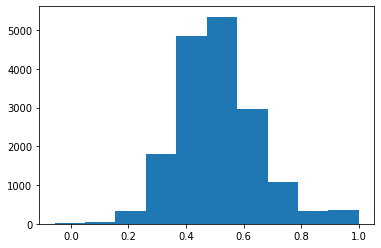

In [69]:
plt.hist(npAnsToDist, bins=10)

(array([  13.,  137.,  987., 3686., 5565., 3900., 1762.,  622.,  194.,
         243.]),
 array([-0.02051357,  0.08153778,  0.18358915,  0.2856405 ,  0.38769186,
         0.4897432 ,  0.59179455,  0.6938459 ,  0.7958973 ,  0.8979486 ,
         1.        ], dtype=float32),
 <BarContainer object of 10 artists>)

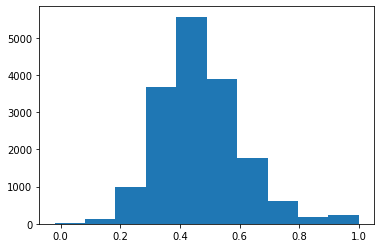

In [70]:
plt.hist(distToDist, bins=10)